In [22]:
from qiskit import *
from qiskit.circuit import Gate
from qiskit.circuit import Parameter

If we rotate the zero qubit about the y-axis by pi/4 degrees, then we can take the |0> state to an equal superposition of 0 and 1. We want to optimize that particular parameter

In [32]:
def forward_prop_circuit(p1):
    """ doing the forward propagation in the quantum circuit."""
    
    circuit = QuantumCircuit(2,2)
    circuit.ry(p1, 0)

    circuit.cx(0,1)
    circuit.measure([0,1], [0,1])
    
    return circuit

Now implementing the gradient descent loop.

In [33]:
#defining the desired probability values
p00 = 0.5
p11 = 0.5

In [34]:
p1 = Parameter('p1')

Building a noise model now. T1/T2 thermal relaxation noise model.

In [57]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

In [58]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u2', 'cx', 'u3', 'reset']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [68]:
from qiskit import *

import numpy as np

lr = 0.01
epochs = 1000
parameter_val = np.random.random()
shots = 1000

#optimizing the circuit to get the desired parameters
for i in range(epochs):
    circuit = forward_prop_circuit(p1)
    circuit.bind_parameters({p1:parameter_val})
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}], basis_gates = 
                 noise_thermal.basis_gates, noise_model = noise_thermal)
    result = job.result().get_counts()
    
    loss = 0
    for key in result.keys():
        if(key == '00'):
            loss += (p00 - (result['00']/shots))**2
        elif(key == '11'):
            loss += (p11 - (result['11']/shots))**2
    
    print('The loss for epoch ' + str(i) + ' is: ' + str(loss))
    
    update = -0.5*np.sin(2*parameter_val)
    parameter_val = parameter_val  - (lr)*update
    
    print('parameter_value for epoch ' + str(i) + ' is: ' +str(parameter_val))

    

The loss for epoch 0 is: 0.352818
parameter_value for epoch 0 is: 0.5803983447285899
The loss for epoch 1 is: 0.36040500000000003
parameter_value for epoch 1 is: 0.5849839495654754
The loss for epoch 2 is: 0.37672000000000005
parameter_value for epoch 2 is: 0.5895876399307435
The loss for epoch 3 is: 0.350297
parameter_value for epoch 3 is: 0.5942090976388844
The loss for epoch 4 is: 0.36637600000000003
parameter_value for epoch 4 is: 0.598847997202458
The loss for epoch 5 is: 0.33623200000000003
parameter_value for epoch 5 is: 0.603504005895336
The loss for epoch 6 is: 0.33459400000000006
parameter_value for epoch 6 is: 0.6081767838224967
The loss for epoch 7 is: 0.34281
parameter_value for epoch 7 is: 0.6128659839964077
The loss for epoch 8 is: 0.34114000000000005
parameter_value for epoch 8 is: 0.6175712524200303
The loss for epoch 9 is: 0.32482600000000006
parameter_value for epoch 9 is: 0.6222922281764647
The loss for epoch 10 is: 0.34279400000000004
parameter_value for epoch 10 i

The loss for epoch 88 is: 0.16192100000000004
parameter_value for epoch 88 is: 1.0068214905137194
The loss for epoch 89 is: 0.15025000000000002
parameter_value for epoch 89 is: 1.0113391679971115
The loss for epoch 90 is: 0.15025000000000002
parameter_value for epoch 90 is: 1.0158373024922447
The loss for epoch 91 is: 0.12354499999999999
parameter_value for epoch 91 is: 1.020315613702449
The loss for epoch 92 is: 0.14003300000000002
parameter_value for epoch 92 is: 1.0247738289389157
The loss for epoch 93 is: 0.15022400000000002
parameter_value for epoch 93 is: 1.02921168314113
The loss for epoch 94 is: 0.12759700000000002
parameter_value for epoch 94 is: 1.0336289188912784
The loss for epoch 95 is: 0.123106
parameter_value for epoch 95 is: 1.0380252864227424
The loss for epoch 96 is: 0.11049999999999999
parameter_value for epoch 96 is: 1.0424005436227948
The loss for epoch 97 is: 0.130781
parameter_value for epoch 97 is: 1.0467544560296203
The loss for epoch 98 is: 0.16537300000000005

The loss for epoch 174 is: 0.02801
parameter_value for epoch 174 is: 1.3100182131588796
The loss for epoch 175 is: 0.02941
parameter_value for epoch 175 is: 1.3125093634563316
The loss for epoch 176 is: 0.038930000000000006
parameter_value for epoch 176 is: 1.3149788835330238
The loss for epoch 177 is: 0.034541
parameter_value for epoch 177 is: 1.3174269006933659
The loss for epoch 178 is: 0.034805
parameter_value for epoch 178 is: 1.3198535432293579
The loss for epoch 179 is: 0.033085
parameter_value for epoch 179 is: 1.3222589403603149
The loss for epoch 180 is: 0.033805
parameter_value for epoch 180 is: 1.3246432221739954
The loss for epoch 181 is: 0.046979999999999994
parameter_value for epoch 181 is: 1.3270065195691212
The loss for epoch 182 is: 0.036445000000000005
parameter_value for epoch 182 is: 1.3293489641992773
The loss for epoch 183 is: 0.03714100000000001
parameter_value for epoch 183 is: 1.3316706884181793
The loss for epoch 184 is: 0.03553300000000001
parameter_value fo

The loss for epoch 259 is: 0.006562000000000004
parameter_value for epoch 259 is: 1.4576783243138076
The loss for epoch 260 is: 0.005986000000000003
parameter_value for epoch 260 is: 1.4587998795225963
The loss for epoch 261 is: 0.01073300000000001
parameter_value for epoch 261 is: 1.4599105021660488
The loss for epoch 262 is: 0.014124999999999999
parameter_value for epoch 262 is: 1.461010293304474
The loss for epoch 263 is: 0.01152100000000001
parameter_value for epoch 263 is: 1.4620993532263236
The loss for epoch 264 is: 0.022983999999999994
parameter_value for epoch 264 is: 1.463177781449143
The loss for epoch 265 is: 0.011620999999999996
parameter_value for epoch 265 is: 1.4642456767206986
The loss for epoch 266 is: 0.006740000000000005
parameter_value for epoch 266 is: 1.465303137020276
The loss for epoch 267 is: 0.0038120000000000007
parameter_value for epoch 267 is: 1.4663502595601385
The loss for epoch 268 is: 0.010421000000000008
parameter_value for epoch 268 is: 1.46738714078

The loss for epoch 344 is: 0.004405000000000001
parameter_value for epoch 344 is: 1.522483089877785
The loss for epoch 345 is: 0.003977000000000001
parameter_value for epoch 345 is: 1.5229654707894928
The loss for epoch 346 is: 0.004937000000000001
parameter_value for epoch 346 is: 1.5234430501699912
The loss for epoch 347 is: 0.002625999999999999
parameter_value for epoch 347 is: 1.5239158753749278
The loss for epoch 348 is: 0.004322000000000001
parameter_value for epoch 348 is: 1.5243839933058883
The loss for epoch 349 is: 0.0025089999999999995
parameter_value for epoch 349 is: 1.5248474504143628
The loss for epoch 350 is: 0.009533000000000007
parameter_value for epoch 350 is: 1.525306292705689
The loss for epoch 351 is: 0.006749000000000004
parameter_value for epoch 351 is: 1.5257605657429736
The loss for epoch 352 is: 0.004589000000000001
parameter_value for epoch 352 is: 1.526210314650988
The loss for epoch 353 is: 0.004329000000000001
parameter_value for epoch 353 is: 1.526655584

The loss for epoch 427 is: 0.002335999999999999
parameter_value for epoch 427 is: 1.5498037506973554
The loss for epoch 428 is: 0.007801000000000006
parameter_value for epoch 428 is: 1.550013614789222
The loss for epoch 429 is: 0.002168999999999999
parameter_value for epoch 429 is: 1.5502213820711668
The loss for epoch 430 is: 0.0016209999999999985
parameter_value for epoch 430 is: 1.5504270734569374
The loss for epoch 431 is: 0.009698000000000009
parameter_value for epoch 431 is: 1.5506307096527572
The loss for epoch 432 is: 0.003434
parameter_value for epoch 432 is: 1.5508323111593523
The loss for epoch 433 is: 0.0007650000000000014
parameter_value for epoch 433 is: 1.55103189827396
The loss for epoch 434 is: 0.003284
parameter_value for epoch 434 is: 1.5512294910923186
The loss for epoch 435 is: 0.0002880000000000005
parameter_value for epoch 435 is: 1.5514251095106388
The loss for epoch 436 is: 0.0034330000000000003
parameter_value for epoch 436 is: 1.5516187732275568
The loss for 

The loss for epoch 509 is: 0.004628000000000001
parameter_value for epoch 509 is: 1.5615875064324438
The loss for epoch 510 is: 0.0007850000000000014
parameter_value for epoch 510 is: 1.5616795894299578
The loss for epoch 511 is: 0.0014499999999999984
parameter_value for epoch 511 is: 1.561770751752113
The loss for epoch 512 is: 0.0006340000000000011
parameter_value for epoch 512 is: 1.5618610026010713
The loss for epoch 513 is: 0.002311999999999999
parameter_value for epoch 513 is: 1.5619503510871091
The loss for epoch 514 is: 0.0018889999999999988
parameter_value for epoch 514 is: 1.5620388062295327
The loss for epoch 515 is: 0.001042000000000002
parameter_value for epoch 515 is: 1.5621263769575835
The loss for epoch 516 is: 0.0004570000000000008
parameter_value for epoch 516 is: 1.562213072111335
The loss for epoch 517 is: 0.005696000000000003
parameter_value for epoch 517 is: 1.562298900442581
The loss for epoch 518 is: 0.0010399999999999982
parameter_value for epoch 518 is: 1.5623

The loss for epoch 591 is: 0.0013699999999999982
parameter_value for epoch 591 is: 1.5667570834005666
The loss for epoch 592 is: 0.0010210000000000017
parameter_value for epoch 592 is: 1.5667974753951632
The loss for epoch 593 is: 0.002160999999999999
parameter_value for epoch 593 is: 1.5668374634828628
The loss for epoch 594 is: 0.0009860000000000016
parameter_value for epoch 594 is: 1.5668770517023465
The loss for epoch 595 is: 0.0006290000000000011
parameter_value for epoch 595 is: 1.5669162440519206
The loss for epoch 596 is: 0.0009700000000000017
parameter_value for epoch 596 is: 1.5669550444899196
The loss for epoch 597 is: 0.0006400000000000011
parameter_value for epoch 597 is: 1.566993456935105
The loss for epoch 598 is: 0.0021639999999999993
parameter_value for epoch 598 is: 1.567031485267061
The loss for epoch 599 is: 0.0027619999999999993
parameter_value for epoch 599 is: 1.5670691333265871
The loss for epoch 600 is: 0.000605000000000001
parameter_value for epoch 600 is: 1.5

The loss for epoch 673 is: 0.0009040000000000016
parameter_value for epoch 673 is: 1.569024636048334
The loss for epoch 674 is: 0.0004820000000000009
parameter_value for epoch 674 is: 1.5690423529187254
The loss for epoch 675 is: 0.00035300000000000067
parameter_value for epoch 675 is: 1.569059892621514
The loss for epoch 676 is: 0.002885
parameter_value for epoch 676 is: 1.569077256928343
The loss for epoch 677 is: 0.0024649999999999993
parameter_value for epoch 677 is: 1.5690944475931408
The loss for epoch 678 is: 0.0013849999999999982
parameter_value for epoch 678 is: 1.5691114663522963
The loss for epoch 679 is: 0.000596000000000001
parameter_value for epoch 679 is: 1.5691283149248363
The loss for epoch 680 is: 0.003188
parameter_value for epoch 680 is: 1.569144995012598
The loss for epoch 681 is: 0.0011239999999999985
parameter_value for epoch 681 is: 1.569161508300401
The loss for epoch 682 is: 0.0003050000000000006
parameter_value for epoch 682 is: 1.5691778564562173
The loss fo

The loss for epoch 755 is: 0.0031329999999999995
parameter_value for epoch 755 is: 1.570019231559045
The loss for epoch 756 is: 0.002080999999999999
parameter_value for epoch 756 is: 1.5700270025082752
The loss for epoch 757 is: 0.002087999999999999
parameter_value for epoch 757 is: 1.570034695748106
The loss for epoch 758 is: 0.0014499999999999984
parameter_value for epoch 758 is: 1.5700423120556284
The loss for epoch 759 is: 0.0017619999999999986
parameter_value for epoch 759 is: 1.5700498522001631
The loss for epoch 760 is: 0.0006410000000000012
parameter_value for epoch 760 is: 1.5700573169433374
The loss for epoch 761 is: 0.0020449999999999986
parameter_value for epoch 761 is: 1.5700647070391622
The loss for epoch 762 is: 0.0015219999999999982
parameter_value for epoch 762 is: 1.5700720232341088
The loss for epoch 763 is: 0.0004610000000000008
parameter_value for epoch 763 is: 1.5700792662671834
The loss for epoch 764 is: 0.0017679999999999985
parameter_value for epoch 764 is: 1.5

The loss for epoch 837 is: 0.000592000000000001
parameter_value for epoch 837 is: 1.570455479167627
The loss for epoch 838 is: 0.0017619999999999986
parameter_value for epoch 838 is: 1.5704588876436358
The loss for epoch 839 is: 0.0014529999999999986
parameter_value for epoch 839 is: 1.5704622620348923
The loss for epoch 840 is: 0.0007450000000000014
parameter_value for epoch 840 is: 1.5704656026822437
The loss for epoch 841 is: 0.0007970000000000015
parameter_value for epoch 841 is: 1.570468909923129
The loss for epoch 842 is: 0.002104999999999999
parameter_value for epoch 842 is: 1.5704721840916127
The loss for epoch 843 is: 0.002289999999999999
parameter_value for epoch 843 is: 1.5704754255184186
The loss for epoch 844 is: 0.0007330000000000013
parameter_value for epoch 844 is: 1.5704786345309631
The loss for epoch 845 is: 0.0007460000000000013
parameter_value for epoch 845 is: 1.5704818114533887
The loss for epoch 846 is: 0.0023529999999999988
parameter_value for epoch 846 is: 1.57

The loss for epoch 919 is: 0.0015879999999999987
parameter_value for epoch 919 is: 1.5706468250553787
The loss for epoch 920 is: 0.0007380000000000014
parameter_value for epoch 920 is: 1.5706483200727517
The loss for epoch 921 is: 0.0019849999999999985
parameter_value for epoch 921 is: 1.5706498001399516
The loss for epoch 922 is: 0.003301
parameter_value for epoch 922 is: 1.5706512654064801
The loss for epoch 923 is: 0.0012889999999999983
parameter_value for epoch 923 is: 1.570652716020344
The loss for epoch 924 is: 0.00043300000000000077
parameter_value for epoch 924 is: 1.57065415212807
The loss for epoch 925 is: 0.000549000000000001
parameter_value for epoch 925 is: 1.570655573874719
The loss for epoch 926 is: 0.0030979999999999996
parameter_value for epoch 926 is: 1.5706569814039022
The loss for epoch 927 is: 0.004810000000000002
parameter_value for epoch 927 is: 1.570658374857794
The loss for epoch 928 is: 0.0009700000000000017
parameter_value for epoch 928 is: 1.5706597543771474

If 'parameter_val' is negative, we will get 0.5*(|00> - |11>). To ensure that the obtained state is 0.5*(|00> + |11>), we force 'parameter_val' to always be positive

In [64]:
parameter_val = np.abs(parameter_val)

Now we'll visualize the final circuit and the final results obtained

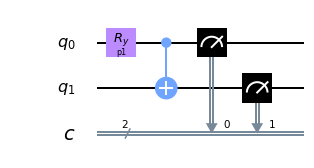

In [65]:

circuit = forward_prop_circuit(p1)
circuit.bind_parameters({p1:parameter_val})

circuit.draw(output = 'mpl')

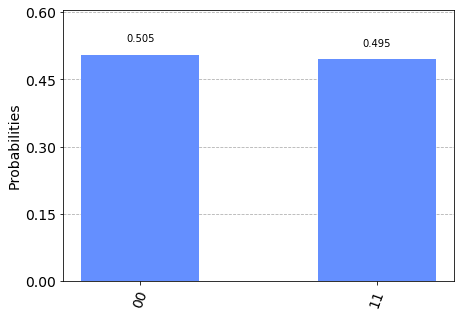

In [67]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#displaying the final results
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}])
result = job.result().get_counts()

plot_histogram(result)

We have obtained the results for 1000 shots. Now we obtain the same result for 10, 100 shots.

This is for 100 shots

In [69]:
from qiskit import *

import numpy as np

lr = 0.01
epochs = 1000
parameter_val = np.random.random()
shots = 100

#optimizing the circuit to get the desired parameters
for i in range(epochs):
    circuit = forward_prop_circuit(p1)
    circuit.bind_parameters({p1:parameter_val})
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}], basis_gates = 
                 noise_thermal.basis_gates, noise_model = noise_thermal)
    result = job.result().get_counts()
    
    loss = 0
    for key in result.keys():
        if(key == '00'):
            loss += (p00 - (result['00']/shots))**2
        elif(key == '11'):
            loss += (p11 - (result['11']/shots))**2
    
    print('The loss for epoch ' + str(i) + ' is: ' + str(loss))
    
    update = -0.5*np.sin(2*parameter_val)
    parameter_val = parameter_val  - (lr)*update
    
    print('parameter_value for epoch ' + str(i) + ' is: ' +str(parameter_val))


The loss for epoch 0 is: 0.2117
parameter_value for epoch 0 is: 0.969948217688342
The loss for epoch 1 is: 0.23139999999999994
parameter_value for epoch 1 is: 0.974611479601765
The loss for epoch 2 is: 0.17410000000000003
parameter_value for epoch 2 is: 0.9792577150024327
The loss for epoch 3 is: 0.18020000000000003
parameter_value for epoch 3 is: 0.9838865841210676
The loss for epoch 4 is: 0.04519999999999999
parameter_value for epoch 4 is: 0.9884977544040284
The loss for epoch 5 is: 0.1405
parameter_value for epoch 5 is: 0.9930909005851132
The loss for epoch 6 is: 0.18610000000000004
parameter_value for epoch 6 is: 0.9976657047507288
The loss for epoch 7 is: 0.2521
parameter_value for epoch 7 is: 1.0022218563984757
The loss for epoch 8 is: 0.17410000000000003
parameter_value for epoch 8 is: 1.0067590524891994
The loss for epoch 9 is: 0.2117
parameter_value for epoch 9 is: 1.011276997492575
The loss for epoch 10 is: 0.1629
parameter_value for epoch 10 is: 1.0157754034262951
The loss f

The loss for epoch 88 is: 0.008500000000000008
parameter_value for epoch 88 is: 1.294573750086936
The loss for epoch 89 is: 0.0032000000000000015
parameter_value for epoch 89 is: 1.29719760117487
The loss for epoch 90 is: 0.028999999999999998
parameter_value for epoch 90 is: 1.2997990808641287
The loss for epoch 91 is: 0.16250000000000003
parameter_value for epoch 91 is: 1.3023783091685681
The loss for epoch 92 is: 0.042499999999999996
parameter_value for epoch 92 is: 1.3049354074822084
The loss for epoch 93 is: 0.1258
parameter_value for epoch 93 is: 1.307470498510342
The loss for epoch 94 is: 0.04329999999999999
parameter_value for epoch 94 is: 1.3099837062020914
The loss for epoch 95 is: 0.026499999999999996
parameter_value for epoch 95 is: 1.3124751556844094
The loss for epoch 96 is: 0.06250000000000001
parameter_value for epoch 96 is: 1.3149449731975194
The loss for epoch 97 is: 0.026899999999999997
parameter_value for epoch 97 is: 1.3173932860317832
The loss for epoch 98 is: 0.03

The loss for epoch 173 is: 0.0074000000000000055
parameter_value for epoch 173 is: 1.4506971694120168
The loss for epoch 174 is: 0.036500000000000005
parameter_value for epoch 174 is: 1.4518866456740895
The loss for epoch 175 is: 0.026499999999999996
parameter_value for epoch 175 is: 1.4530645653075016
The loss for epoch 176 is: 0.004500000000000001
parameter_value for epoch 176 is: 1.4542310340236178
The loss for epoch 177 is: 0.026899999999999997
parameter_value for epoch 177 is: 1.4553861567603292
The loss for epoch 178 is: 0.00010000000000000018
parameter_value for epoch 178 is: 1.456530037681798
The loss for epoch 179 is: 0.010000000000000009
parameter_value for epoch 179 is: 1.4576627801784205
The loss for epoch 180 is: 0.0037
parameter_value for epoch 180 is: 1.4587844868670026
The loss for epoch 181 is: 0.0514
parameter_value for epoch 181 is: 1.4598952595911383
The loss for epoch 182 is: 0.0074000000000000055
parameter_value for epoch 182 is: 1.4609951994217871
The loss for ep

The loss for epoch 255 is: 0.024199999999999996
parameter_value for epoch 255 is: 1.5179102333549694
The loss for epoch 256 is: 0.008000000000000005
parameter_value for epoch 256 is: 1.5184381087130434
The loss for epoch 257 is: 0.005800000000000002
parameter_value for epoch 257 is: 1.518960734525507
The loss for epoch 258 is: 0.005800000000000002
parameter_value for epoch 258 is: 1.5194781624234703
The loss for epoch 259 is: 0.0074000000000000055
parameter_value for epoch 259 is: 1.5199904435472507
The loss for epoch 260 is: 0.00010000000000000018
parameter_value for epoch 260 is: 1.5204976285505285
The loss for epoch 261 is: 0.0016999999999999986
parameter_value for epoch 261 is: 1.5209997676044869
The loss for epoch 262 is: 0.004100000000000001
parameter_value for epoch 262 is: 1.5214969104019282
The loss for epoch 263 is: 0.0028999999999999994
parameter_value for epoch 263 is: 1.5219891061613724
The loss for epoch 264 is: 0.002599999999999999
parameter_value for epoch 264 is: 1.522

The loss for epoch 337 is: 0.0369
parameter_value for epoch 337 is: 1.547581815468847
The loss for epoch 338 is: 0.022499999999999992
parameter_value for epoch 338 is: 1.5478138771870007
The loss for epoch 339 is: 0.0016999999999999986
parameter_value for epoch 339 is: 1.5480436207638364
The loss for epoch 340 is: 0.001999999999999999
parameter_value for epoch 340 is: 1.5482710693072836
The loss for epoch 341 is: 0.005200000000000003
parameter_value for epoch 341 is: 1.548496245696372
The loss for epoch 342 is: 0.002599999999999999
parameter_value for epoch 342 is: 1.5487191725834568
The loss for epoch 343 is: 0.0016999999999999986
parameter_value for epoch 343 is: 1.548939872396422
The loss for epoch 344 is: 0.01809999999999999
parameter_value for epoch 344 is: 1.5491583673408649
The loss for epoch 345 is: 0.008000000000000005
parameter_value for epoch 345 is: 1.5493746794022591
The loss for epoch 346 is: 0.0010000000000000018
parameter_value for epoch 346 is: 1.5495888303480998
The l

The loss for epoch 421 is: 0.0074000000000000055
parameter_value for epoch 421 is: 1.5608151795898906
The loss for epoch 422 is: 0.0317
parameter_value for epoch 422 is: 1.5609149844330406
The loss for epoch 423 is: 0.0037
parameter_value for epoch 423 is: 1.5610137914246285
The loss for epoch 424 is: 0.0034000000000000002
parameter_value for epoch 424 is: 1.5611116105373235
The loss for epoch 425 is: 0.001999999999999999
parameter_value for epoch 425 is: 1.5612084516442417
The loss for epoch 426 is: 0.005200000000000003
parameter_value for epoch 426 is: 1.5613043245199365
The loss for epoch 427 is: 0.0018000000000000032
parameter_value for epoch 427 is: 1.5613992388413793
The loss for epoch 428 is: 0.0013000000000000023
parameter_value for epoch 428 is: 1.56149320418893
The loss for epoch 429 is: 0.005300000000000002
parameter_value for epoch 429 is: 1.5615862300472994
The loss for epoch 430 is: 0.0016999999999999986
parameter_value for epoch 430 is: 1.5616783258065
The loss for epoch

The loss for epoch 506 is: 0.0037
parameter_value for epoch 506 is: 1.566548331855544
The loss for epoch 507 is: 0.008900000000000007
parameter_value for epoch 507 is: 1.5665908112938924
The loss for epoch 508 is: 0.014499999999999999
parameter_value for epoch 508 is: 1.5666328659530357
The loss for epoch 509 is: 0.012799999999999995
parameter_value for epoch 509 is: 1.5666745000803153
The loss for epoch 510 is: 0.018499999999999992
parameter_value for epoch 510 is: 1.5667157178806121
The loss for epoch 511 is: 0.00020000000000000036
parameter_value for epoch 511 is: 1.5667565235167717
The loss for epoch 512 is: 0.0005000000000000009
parameter_value for epoch 512 is: 1.5667969211100234
The loss for epoch 513 is: 0.006500000000000004
parameter_value for epoch 513 is: 1.566836914740397
The loss for epoch 514 is: 0.009700000000000007
parameter_value for epoch 514 is: 1.5668765084471334
The loss for epoch 515 is: 0.010000000000000009
parameter_value for epoch 515 is: 1.5669157062290928
The

The loss for epoch 589 is: 0.004100000000000001
parameter_value for epoch 589 is: 1.568951705176014
The loss for epoch 590 is: 0.0028999999999999994
parameter_value for epoch 590 is: 1.568970151350359
The loss for epoch 591 is: 0.009700000000000007
parameter_value for epoch 591 is: 1.5689884130642036
The loss for epoch 592 is: 0.006100000000000005
parameter_value for epoch 592 is: 1.5690064921621154
The loss for epoch 593 is: 0.0025
parameter_value for epoch 593 is: 1.5690243904702184
The loss for epoch 594 is: 0.004500000000000001
parameter_value for epoch 594 is: 1.5690421097963754
The loss for epoch 595 is: 0.006800000000000004
parameter_value for epoch 595 is: 1.5690596519303726
The loss for epoch 596 is: 0.010600000000000009
parameter_value for epoch 596 is: 1.5690770186440985
The loss for epoch 597 is: 0.0010000000000000018
parameter_value for epoch 597 is: 1.5690942116917246
The loss for epoch 598 is: 0.004000000000000001
parameter_value for epoch 598 is: 1.5691112328098806
The 

The loss for epoch 673 is: 0.022499999999999992
parameter_value for epoch 673 is: 1.5700033434825078
The loss for epoch 674 is: 0.0008000000000000014
parameter_value for epoch 674 is: 1.5700112733123075
The loss for epoch 675 is: 0.00020000000000000036
parameter_value for epoch 675 is: 1.5700191238439078
The loss for epoch 676 is: 0.005800000000000002
parameter_value for epoch 676 is: 1.5700268958702879
The loss for epoch 677 is: 0.018499999999999992
parameter_value for epoch 677 is: 1.5700345901764972
The loss for epoch 678 is: 0.0016999999999999986
parameter_value for epoch 678 is: 1.5700422075397344
The loss for epoch 679 is: 0.012999999999999998
parameter_value for epoch 679 is: 1.570049748729427
The loss for epoch 680 is: 0.008500000000000006
parameter_value for epoch 680 is: 1.5700572145073075
The loss for epoch 681 is: 0.012999999999999998
parameter_value for epoch 681 is: 1.5700646056274916
The loss for epoch 682 is: 0.005800000000000002
parameter_value for epoch 682 is: 1.5700

The loss for epoch 757 is: 0.0034000000000000002
parameter_value for epoch 757 is: 1.5704554319218595
The loss for epoch 758 is: 0.002599999999999999
parameter_value for epoch 758 is: 1.5704588408703257
The loss for epoch 759 is: 0.026899999999999997
parameter_value for epoch 759 is: 1.570462215729315
The loss for epoch 760 is: 0.0010000000000000018
parameter_value for epoch 760 is: 1.5704655568397223
The loss for epoch 761 is: 0.0015999999999999983
parameter_value for epoch 761 is: 1.5704688645390328
The loss for epoch 762 is: 0.00020000000000000036
parameter_value for epoch 762 is: 1.5704721391613574
The loss for epoch 763 is: 0.0010000000000000018
parameter_value for epoch 763 is: 1.5704753810374656
The loss for epoch 764 is: 0.008900000000000007
parameter_value for epoch 764 is: 1.5704785904948195
The loss for epoch 765 is: 0.0005000000000000009
parameter_value for epoch 765 is: 1.5704817678576064
The loss for epoch 766 is: 0.008500000000000008
parameter_value for epoch 766 is: 1.5

The loss for epoch 840 is: 0.0034000000000000002
parameter_value for epoch 840 is: 1.5706482995571567
The loss for epoch 841 is: 0.0028999999999999994
parameter_value for epoch 841 is: 1.5706497798295125
The loss for epoch 842 is: 0.006100000000000005
parameter_value for epoch 842 is: 1.5706512452991452
The loss for epoch 843 is: 0.0004000000000000007
parameter_value for epoch 843 is: 1.5706526961140823
The loss for epoch 844 is: 0.0016999999999999986
parameter_value for epoch 844 is: 1.5706541324208707
The loss for epoch 845 is: 0.005800000000000002
parameter_value for epoch 845 is: 1.5706555543645917
The loss for epoch 846 is: 0.0028999999999999994
parameter_value for epoch 846 is: 1.5706569620888762
The loss for epoch 847 is: 0.010600000000000009
parameter_value for epoch 847 is: 1.5706583557359184
The loss for epoch 848 is: 0.008900000000000007
parameter_value for epoch 848 is: 1.5706597354464906
The loss for epoch 849 is: 0.002599999999999999
parameter_value for epoch 849 is: 1.57

The loss for epoch 922 is: 0.0016999999999999986
parameter_value for epoch 922 is: 1.5707313994572907
The loss for epoch 923 is: 0.0009000000000000016
parameter_value for epoch 923 is: 1.5707320487306649
The loss for epoch 924 is: 0.010000000000000009
parameter_value for epoch 924 is: 1.5707326915113053
The loss for epoch 925 is: 0.005800000000000002
parameter_value for epoch 925 is: 1.5707333278641396
The loss for epoch 926 is: 0.008000000000000005
parameter_value for epoch 926 is: 1.5707339578534454
The loss for epoch 927 is: 0.001999999999999999
parameter_value for epoch 927 is: 1.5707345815428584
The loss for epoch 928 is: 0.005800000000000002
parameter_value for epoch 928 is: 1.5707351989953773
The loss for epoch 929 is: 0.005800000000000002
parameter_value for epoch 929 is: 1.570735810273371
The loss for epoch 930 is: 0.00020000000000000036
parameter_value for epoch 930 is: 1.5707364154385848
The loss for epoch 931 is: 0.0013000000000000023
parameter_value for epoch 931 is: 1.570

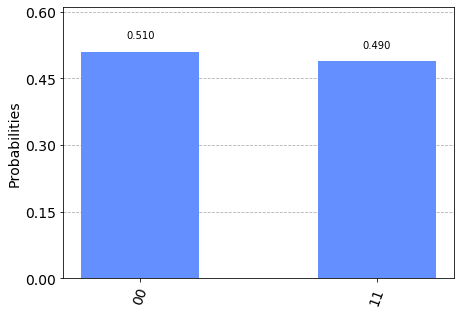

In [70]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#displaying the final results
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}])
result = job.result().get_counts()

plot_histogram(result)

For 10 shots

In [81]:
from qiskit import *

import numpy as np

lr = 0.01
epochs = 1000
parameter_val = np.random.random()
shots = 10

#optimizing the circuit to get the desired parameters
for i in range(epochs):
    circuit = forward_prop_circuit(p1)
    circuit.bind_parameters({p1:parameter_val})
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}], basis_gates = 
                 noise_thermal.basis_gates, noise_model = noise_thermal)
    result = job.result().get_counts()
    
    loss = 0
    for key in result.keys():
        if(key == '00'):
            loss += (p00 - (result['00']/shots))**2
        elif(key == '11'):
            loss += (p11 - (result['11']/shots))**2
    
    print('The loss for epoch ' + str(i) + ' is: ' + str(loss))
    
    update = -0.5*np.sin(2*parameter_val)
    parameter_val = parameter_val  - (lr)*update
    
    print('parameter_value for epoch ' + str(i) + ' is: ' +str(parameter_val))

The loss for epoch 0 is: 0.25
parameter_value for epoch 0 is: 0.5805869140960149
The loss for epoch 1 is: 0.32000000000000006
parameter_value for epoch 1 is: 0.5851732702612301
The loss for epoch 2 is: 0.07999999999999999
parameter_value for epoch 2 is: 0.5897776989903067
The loss for epoch 3 is: 0.32000000000000006
parameter_value for epoch 3 is: 0.5943998817957247
The loss for epoch 4 is: 0.18000000000000002
parameter_value for epoch 4 is: 0.5990394928905097
The loss for epoch 5 is: 0.32000000000000006
parameter_value for epoch 5 is: 0.6036961992517462
The loss for epoch 6 is: 0.18000000000000002
parameter_value for epoch 6 is: 0.608369660690641
The loss for epoch 7 is: 0.25
parameter_value for epoch 7 is: 0.6130595299291794
The loss for epoch 8 is: 0.25
parameter_value for epoch 8 is: 0.6177654526834029
The loss for epoch 9 is: 0.25
parameter_value for epoch 9 is: 0.6224870677533275
The loss for epoch 10 is: 0.25
parameter_value for epoch 10 is: 0.6272240071195134
The loss for epoch

The loss for epoch 89 is: 0.32000000000000006
parameter_value for epoch 89 is: 1.0115248827215204
The loss for epoch 90 is: 0.18000000000000002
parameter_value for epoch 90 is: 1.0160222059655666
The loss for epoch 91 is: 0.18000000000000002
parameter_value for epoch 91 is: 1.0204996945392566
The loss for epoch 92 is: 0.18000000000000002
parameter_value for epoch 92 is: 1.0249570760677118
The loss for epoch 93 is: 0.18000000000000002
parameter_value for epoch 93 is: 1.029394085805059
The loss for epoch 94 is: 0.32000000000000006
parameter_value for epoch 94 is: 1.0338104666485926
The loss for epoch 95 is: 0.32000000000000006
parameter_value for epoch 95 is: 1.0382059691470267
The loss for epoch 96 is: 0.25
parameter_value for epoch 96 is: 1.042580351502955
The loss for epoch 97 is: 0.01999999999999999
parameter_value for epoch 97 is: 1.0469333795696407
The loss for epoch 98 is: 0.0
parameter_value for epoch 98 is: 1.0512648268422662
The loss for epoch 99 is: 0.25
parameter_value for ep

The loss for epoch 176 is: 0.0
parameter_value for epoch 176 is: 1.3150801676574237
The loss for epoch 177 is: 0.0
parameter_value for epoch 177 is: 1.3175273016254574
The loss for epoch 178 is: 0.32000000000000006
parameter_value for epoch 178 is: 1.3199530662751733
The loss for epoch 179 is: 0.0
parameter_value for epoch 179 is: 1.3223575908628205
The loss for epoch 180 is: 0.01999999999999999
parameter_value for epoch 180 is: 1.3247410055106954
The loss for epoch 181 is: 0.07999999999999999
parameter_value for epoch 181 is: 1.3271034411497193
The loss for epoch 182 is: 0.0
parameter_value for epoch 182 is: 1.3294450294633953
The loss for epoch 183 is: 0.01999999999999999
parameter_value for epoch 183 is: 1.3317659028331306
The loss for epoch 184 is: 0.18000000000000002
parameter_value for epoch 184 is: 1.3340661942849146
The loss for epoch 185 is: 0.01999999999999999
parameter_value for epoch 185 is: 1.3363460374373337
The loss for epoch 186 is: 0.07999999999999999
parameter_value f

The loss for epoch 261 is: 0.009999999999999995
parameter_value for epoch 261 is: 1.4599560276984953
The loss for epoch 262 is: 0.009999999999999995
parameter_value for epoch 262 is: 1.4610553747265633
The loss for epoch 263 is: 0.32000000000000006
parameter_value for epoch 263 is: 1.4621439946534782
The loss for epoch 264 is: 0.009999999999999995
parameter_value for epoch 264 is: 1.4632219869650467
The loss for epoch 265 is: 0.0
parameter_value for epoch 265 is: 1.4642894503773467
The loss for epoch 266 is: 0.009999999999999995
parameter_value for epoch 266 is: 1.4653464828380314
The loss for epoch 267 is: 0.0
parameter_value for epoch 267 is: 1.466393181527796
The loss for epoch 268 is: 0.01999999999999999
parameter_value for epoch 268 is: 1.4674296428620008
The loss for epoch 269 is: 0.18000000000000002
parameter_value for epoch 269 is: 1.4684559624924456
The loss for epoch 270 is: 0.07999999999999999
parameter_value for epoch 270 is: 1.4694722353092877
The loss for epoch 271 is: 0.

The loss for epoch 349 is: 0.0
parameter_value for epoch 349 is: 1.5248664459234826
The loss for epoch 350 is: 0.05
parameter_value for epoch 350 is: 1.5253250990609264
The loss for epoch 351 is: 0.009999999999999995
parameter_value for epoch 351 is: 1.5257791848121365
The loss for epoch 352 is: 0.01999999999999999
parameter_value for epoch 352 is: 1.526228748283908
The loss for epoch 353 is: 0.07999999999999999
parameter_value for epoch 353 is: 1.5266738341487347
The loss for epoch 354 is: 0.01999999999999999
parameter_value for epoch 354 is: 1.5271144866486563
The loss for epoch 355 is: 0.07999999999999999
parameter_value for epoch 355 is: 1.527550749599085
The loss for epoch 356 is: 0.01999999999999999
parameter_value for epoch 356 is: 1.5279826663926048
The loss for epoch 357 is: 0.0
parameter_value for epoch 357 is: 1.5284102800027486
The loss for epoch 358 is: 0.01999999999999999
parameter_value for epoch 358 is: 1.5288336329877494
The loss for epoch 359 is: 0.01999999999999999
p

The loss for epoch 438 is: 0.01999999999999999
parameter_value for epoch 438 is: 1.552008093994415
The loss for epoch 439 is: 0.009999999999999995
parameter_value for epoch 439 is: 1.5521959321108558
The loss for epoch 440 is: 0.0
parameter_value for epoch 440 is: 1.5523818931588937
The loss for epoch 441 is: 0.18000000000000002
parameter_value for epoch 441 is: 1.5525659958702405
The loss for epoch 442 is: 0.01999999999999999
parameter_value for epoch 442 is: 1.552748258790447
The loss for epoch 443 is: 0.07999999999999999
parameter_value for epoch 443 is: 1.5529287002807315
The loss for epoch 444 is: 0.05
parameter_value for epoch 444 is: 1.5531073385197887
The loss for epoch 445 is: 0.07999999999999999
parameter_value for epoch 445 is: 1.5532841915055833
The loss for epoch 446 is: 0.07999999999999999
parameter_value for epoch 446 is: 1.5534592770571254
The loss for epoch 447 is: 0.05
parameter_value for epoch 447 is: 1.5536326128162306
The loss for epoch 448 is: 0.05
parameter_value

The loss for epoch 524 is: 0.01999999999999999
parameter_value for epoch 524 is: 1.5628794235316303
The loss for epoch 525 is: 0.07999999999999999
parameter_value for epoch 525 is: 1.5629585892562339
The loss for epoch 526 is: 0.01999999999999999
parameter_value for epoch 526 is: 1.5630369634218384
The loss for epoch 527 is: 0.32000000000000006
parameter_value for epoch 527 is: 1.563114553941116
The loss for epoch 528 is: 0.01999999999999999
parameter_value for epoch 528 is: 1.5631913686476988
The loss for epoch 529 is: 0.0
parameter_value for epoch 529 is: 1.5632674152969666
The loss for epoch 530 is: 0.01999999999999999
parameter_value for epoch 530 is: 1.563342701566827
The loss for epoch 531 is: 0.07999999999999999
parameter_value for epoch 531 is: 1.563417235058488
The loss for epoch 532 is: 0.0
parameter_value for epoch 532 is: 1.5634910232972221
The loss for epoch 533 is: 0.01999999999999999
parameter_value for epoch 533 is: 1.5635640737331233
The loss for epoch 534 is: 0.009999

The loss for epoch 612 is: 0.01999999999999999
parameter_value for epoch 612 is: 1.5675269866792636
The loss for epoch 613 is: 0.12999999999999998
parameter_value for epoch 613 is: 1.5675596798474563
The loss for epoch 614 is: 0.07999999999999999
parameter_value for epoch 614 is: 1.5675920460908863
The loss for epoch 615 is: 0.05
parameter_value for epoch 615 is: 1.5676240886785957
The loss for epoch 616 is: 0.07999999999999999
parameter_value for epoch 616 is: 1.5676558108469423
The loss for epoch 617 is: 0.18000000000000002
parameter_value for epoch 617 is: 1.5676872157999262
The loss for epoch 618 is: 0.0
parameter_value for epoch 618 is: 1.5677183067095133
The loss for epoch 619 is: 0.01999999999999999
parameter_value for epoch 619 is: 1.5677490867159556
The loss for epoch 620 is: 0.32000000000000006
parameter_value for epoch 620 is: 1.5677795589281076
The loss for epoch 621 is: 0.05
parameter_value for epoch 621 is: 1.5678097264237407
The loss for epoch 622 is: 0.0
parameter_value

The loss for epoch 698 is: 0.18000000000000002
parameter_value for epoch 698 is: 1.5694188378224967
The loss for epoch 699 is: 0.009999999999999995
parameter_value for epoch 699 is: 1.5694326126947957
The loss for epoch 700 is: 0.05
parameter_value for epoch 700 is: 1.5694462498188892
The loss for epoch 701 is: 0.0
parameter_value for epoch 701 is: 1.569459750572244
The loss for epoch 702 is: 0.0
parameter_value for epoch 702 is: 1.5694731163185525
The loss for epoch 703 is: 0.009999999999999995
parameter_value for epoch 703 is: 1.5694863484078707
The loss for epoch 704 is: 0.01999999999999999
parameter_value for epoch 704 is: 1.5694994481767544
The loss for epoch 705 is: 0.01999999999999999
parameter_value for epoch 705 is: 1.5695124169483943
The loss for epoch 706 is: 0.01999999999999999
parameter_value for epoch 706 is: 1.5695252560327497
The loss for epoch 707 is: 0.01999999999999999
parameter_value for epoch 707 is: 1.5695379667266807
The loss for epoch 708 is: 0.01999999999999999

The loss for epoch 785 is: 0.0
parameter_value for epoch 785 is: 1.5702217470778888
The loss for epoch 786 is: 0.01999999999999999
parameter_value for epoch 786 is: 1.5702274928737943
The loss for epoch 787 is: 0.07999999999999999
parameter_value for epoch 787 is: 1.5702331812117782
The loss for epoch 788 is: 0.01999999999999999
parameter_value for epoch 788 is: 1.5702388126664188
The loss for epoch 789 is: 0.01999999999999999
parameter_value for epoch 789 is: 1.5702443878065484
The loss for epoch 790 is: 0.01999999999999999
parameter_value for epoch 790 is: 1.5702499071953109
The loss for epoch 791 is: 0.07999999999999999
parameter_value for epoch 791 is: 1.5702553713902192
The loss for epoch 792 is: 0.0
parameter_value for epoch 792 is: 1.5702607809432105
The loss for epoch 793 is: 0.01999999999999999
parameter_value for epoch 793 is: 1.5702661364007033
The loss for epoch 794 is: 0.01999999999999999
parameter_value for epoch 794 is: 1.5702714383036518
The loss for epoch 795 is: 0.079

The loss for epoch 871 is: 0.01999999999999999
parameter_value for epoch 871 is: 1.5705542366745207
The loss for epoch 872 is: 0.07999999999999999
parameter_value for epoch 872 is: 1.5705566575756298
The loss for epoch 873 is: 0.01999999999999999
parameter_value for epoch 873 is: 1.5705590542677306
The loss for epoch 874 is: 0.009999999999999995
parameter_value for epoch 874 is: 1.5705614269929131
The loss for epoch 875 is: 0.0
parameter_value for epoch 875 is: 1.5705637759908466
The loss for epoch 876 is: 0.0
parameter_value for epoch 876 is: 1.5705661014988033
The loss for epoch 877 is: 0.0
parameter_value for epoch 877 is: 1.570568403751683
The loss for epoch 878 is: 0.009999999999999995
parameter_value for epoch 878 is: 1.570570682982036
The loss for epoch 879 is: 0.05
parameter_value for epoch 879 is: 1.570572939420088
The loss for epoch 880 is: 0.07999999999999999
parameter_value for epoch 880 is: 1.5705751732937618
The loss for epoch 881 is: 0.01999999999999999
parameter_value f

The loss for epoch 957 is: 0.0
parameter_value for epoch 957 is: 1.570694325940673
The loss for epoch 958 is: 0.0
parameter_value for epoch 958 is: 1.5706953459492081
The loss for epoch 959 is: 0.009999999999999995
parameter_value for epoch 959 is: 1.570696355757658
The loss for epoch 960 is: 0.01999999999999999
parameter_value for epoch 960 is: 1.570697355468024
The loss for epoch 961 is: 0.01999999999999999
parameter_value for epoch 961 is: 1.5706983451812861
The loss for epoch 962 is: 0.0
parameter_value for epoch 962 is: 1.570699324997416
The loss for epoch 963 is: 0.0
parameter_value for epoch 963 is: 1.5707002950153846
The loss for epoch 964 is: 0.07999999999999999
parameter_value for epoch 964 is: 1.5707012553331738
The loss for epoch 965 is: 0.01999999999999999
parameter_value for epoch 965 is: 1.5707022060477853
The loss for epoch 966 is: 0.009999999999999995
parameter_value for epoch 966 is: 1.5707031472552508
The loss for epoch 967 is: 0.009999999999999995
parameter_value fo

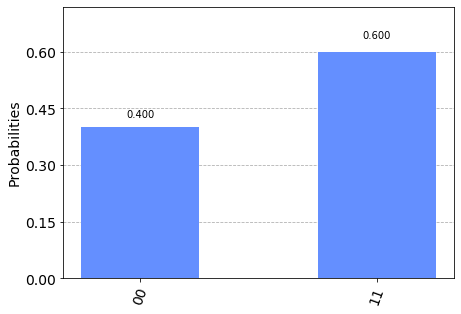

In [82]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#displaying the final results
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}])
result = job.result().get_counts()

plot_histogram(result)

for 1 shot

In [83]:
from qiskit import *

import numpy as np

lr = 0.01
epochs = 1000
parameter_val = np.random.random()
shots = 1

#optimizing the circuit to get the desired parameters
for i in range(epochs):
    circuit = forward_prop_circuit(p1)
    circuit.bind_parameters({p1:parameter_val})
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}], basis_gates = 
                 noise_thermal.basis_gates, noise_model = noise_thermal)
    result = job.result().get_counts()
    
    loss = 0
    for key in result.keys():
        if(key == '00'):
            loss += (p00 - (result['00']/shots))**2
        elif(key == '11'):
            loss += (p11 - (result['11']/shots))**2
    
    print('The loss for epoch ' + str(i) + ' is: ' + str(loss))
    
    update = -0.5*np.sin(2*parameter_val)
    parameter_val = parameter_val  - (lr)*update
    
    print('parameter_value for epoch ' + str(i) + ' is: ' +str(parameter_val))

The loss for epoch 0 is: 0.25
parameter_value for epoch 0 is: 0.6658917324578568
The loss for epoch 1 is: 0.25
parameter_value for epoch 1 is: 0.6707495931922659
The loss for epoch 2 is: 0.25
parameter_value for epoch 2 is: 0.6756187251456638
The loss for epoch 3 is: 0.25
parameter_value for epoch 3 is: 0.6804986932486234
The loss for epoch 4 is: 0.25
parameter_value for epoch 4 is: 0.6853890572878276
The loss for epoch 5 is: 0.25
parameter_value for epoch 5 is: 0.690289372085174
The loss for epoch 6 is: 0.25
parameter_value for epoch 6 is: 0.6951991876824662
The loss for epoch 7 is: 0.25
parameter_value for epoch 7 is: 0.7001180495315257
The loss for epoch 8 is: 0.25
parameter_value for epoch 8 is: 0.7050454986895528
The loss for epoch 9 is: 0.25
parameter_value for epoch 9 is: 0.7099810720195514
The loss for epoch 10 is: 0.25
parameter_value for epoch 10 is: 0.7149243023956204
The loss for epoch 11 is: 0.25
parameter_value for epoch 11 is: 0.7198747189129087
The loss for epoch 12 is:

The loss for epoch 100 is: 0.25
parameter_value for epoch 100 is: 1.1332912009120832
The loss for epoch 101 is: 0.25
parameter_value for epoch 101 is: 1.1371289512798095
The loss for epoch 102 is: 0.25
parameter_value for epoch 102 is: 1.140941989285039
The loss for epoch 103 is: 0.25
parameter_value for epoch 103 is: 1.1447302515820703
The loss for epoch 104 is: 0.25
parameter_value for epoch 104 is: 1.1484936809807464
The loss for epoch 105 is: 0.25
parameter_value for epoch 105 is: 1.1522322263488618
The loss for epoch 106 is: 0
parameter_value for epoch 106 is: 1.1559458425130533
The loss for epoch 107 is: 0.25
parameter_value for epoch 107 is: 1.1596344901583147
The loss for epoch 108 is: 0.25
parameter_value for epoch 108 is: 1.1632981357262724
The loss for epoch 109 is: 0.25
parameter_value for epoch 109 is: 1.1669367513123579
The loss for epoch 110 is: 0.25
parameter_value for epoch 110 is: 1.1705503145620058
The loss for epoch 111 is: 0.25
parameter_value for epoch 111 is: 1.1

The loss for epoch 197 is: 0.25
parameter_value for epoch 197 is: 1.396002106090025
The loss for epoch 198 is: 0.25
parameter_value for epoch 198 is: 1.397714661947609
The loss for epoch 199 is: 0.25
parameter_value for epoch 199 is: 1.3994111180934734
The loss for epoch 200 is: 0.25
parameter_value for epoch 200 is: 1.4010916062581755
The loss for epoch 201 is: 0.25
parameter_value for epoch 201 is: 1.4027562576673578
The loss for epoch 202 is: 0.25
parameter_value for epoch 202 is: 1.404405203025319
The loss for epoch 203 is: 0.25
parameter_value for epoch 203 is: 1.4060385724992663
The loss for epoch 204 is: 0.25
parameter_value for epoch 204 is: 1.4076564957042335
The loss for epoch 205 is: 0.25
parameter_value for epoch 205 is: 1.4092591016886438
The loss for epoch 206 is: 0.25
parameter_value for epoch 206 is: 1.410846518920507
The loss for epoch 207 is: 0.25
parameter_value for epoch 207 is: 1.4124188752742304
The loss for epoch 208 is: 0.25
parameter_value for epoch 208 is: 1.4

The loss for epoch 296 is: 0.25
parameter_value for epoch 296 is: 1.505587246585193
The loss for epoch 297 is: 0.25
parameter_value for epoch 297 is: 1.5062374904012488
The loss for epoch 298 is: 0.25
parameter_value for epoch 298 is: 1.5068812864524044
The loss for epoch 299 is: 0.25
parameter_value for epoch 299 is: 1.5075186976014479
The loss for epoch 300 is: 0.25
parameter_value for epoch 300 is: 1.5081497861300637
The loss for epoch 301 is: 0.25
parameter_value for epoch 301 is: 1.508774613743254
The loss for epoch 302 is: 0.25
parameter_value for epoch 302 is: 1.5093932415737557
The loss for epoch 303 is: 0.25
parameter_value for epoch 303 is: 1.5100057301864513
The loss for epoch 304 is: 0.25
parameter_value for epoch 304 is: 1.510612139582776
The loss for epoch 305 is: 0.25
parameter_value for epoch 305 is: 1.511212529205115
The loss for epoch 306 is: 0.25
parameter_value for epoch 306 is: 1.5118069579411948
The loss for epoch 307 is: 0.25
parameter_value for epoch 307 is: 1.5

The loss for epoch 395 is: 0.25
parameter_value for epoch 395 is: 1.5466566071250587
The loss for epoch 396 is: 0.25
parameter_value for epoch 396 is: 1.5468979105537268
The loss for epoch 397 is: 0.25
parameter_value for epoch 397 is: 1.5471368037318307
The loss for epoch 398 is: 0.25
parameter_value for epoch 398 is: 1.5473733106792593
The loss for epoch 399 is: 0.25
parameter_value for epoch 399 is: 1.5476074551781536
The loss for epoch 400 is: 0.25
parameter_value for epoch 400 is: 1.5478392607752112
The loss for epoch 401 is: 0.25
parameter_value for epoch 401 is: 1.5480687507839703
The loss for epoch 402 is: 0.25
parameter_value for epoch 402 is: 1.548295948287073
The loss for epoch 403 is: 0.25
parameter_value for epoch 403 is: 1.5485208761385079
The loss for epoch 404 is: 0.25
parameter_value for epoch 404 is: 1.5487435569658314
The loss for epoch 405 is: 0.25
parameter_value for epoch 405 is: 1.5489640131723712
The loss for epoch 406 is: 0.25
parameter_value for epoch 406 is: 

The loss for epoch 493 is: 0.25
parameter_value for epoch 493 is: 1.5617794736948627
The loss for epoch 494 is: 0.25
parameter_value for epoch 494 is: 1.5618696373385894
The loss for epoch 495 is: 0.25
parameter_value for epoch 495 is: 1.5619588994910263
The loss for epoch 496 is: 0.25
parameter_value for epoch 496 is: 1.5620472691627758
The loss for epoch 497 is: 0.25
parameter_value for epoch 497 is: 1.5621347552744624
The loss for epoch 498 is: 0.25
parameter_value for epoch 498 is: 1.5622213666576283
The loss for epoch 499 is: 0.25
parameter_value for epoch 499 is: 1.5623071120556207
The loss for epoch 500 is: 0.25
parameter_value for epoch 500 is: 1.5623920001244704
The loss for epoch 501 is: 0.25
parameter_value for epoch 501 is: 1.5624760394337616
The loss for epoch 502 is: 0.25
parameter_value for epoch 502 is: 1.5625592384674925
The loss for epoch 503 is: 0.25
parameter_value for epoch 503 is: 1.5626416056249282
The loss for epoch 504 is: 0.25
parameter_value for epoch 504 is:

The loss for epoch 591 is: 0.25
parameter_value for epoch 591 is: 1.5674287745122957
The loss for epoch 592 is: 0.25
parameter_value for epoch 592 is: 1.567462449780526
The loss for epoch 593 is: 0.25
parameter_value for epoch 593 is: 1.567495788303636
The loss for epoch 594 is: 0.25
parameter_value for epoch 594 is: 1.5675287934488518
The loss for epoch 595 is: 0.25
parameter_value for epoch 595 is: 1.5675614685497345
The loss for epoch 596 is: 0.25
parameter_value for epoch 596 is: 1.5675938169065162
The loss for epoch 597 is: 0.25
parameter_value for epoch 597 is: 1.5676258417864326
The loss for epoch 598 is: 0.25
parameter_value for epoch 598 is: 1.5676575464240534
The loss for epoch 599 is: 0.25
parameter_value for epoch 599 is: 1.5676889340216085
The loss for epoch 600 is: 0.25
parameter_value for epoch 600 is: 1.5677200077493108
The loss for epoch 601 is: 0.25
parameter_value for epoch 601 is: 1.567750770745677
The loss for epoch 602 is: 0.25
parameter_value for epoch 602 is: 1.

The loss for epoch 690 is: 0.25
parameter_value for epoch 690 is: 1.5695512387848063
The loss for epoch 691 is: 0.25
parameter_value for epoch 691 is: 1.5695636896520393
The loss for epoch 692 is: 0.25
parameter_value for epoch 692 is: 1.5695760160109822
The loss for epoch 693 is: 0.25
parameter_value for epoch 693 is: 1.5695882191067063
The loss for epoch 694 is: 0.25
parameter_value for epoch 694 is: 1.569600300171833
The loss for epoch 695 is: 0.25
parameter_value for epoch 695 is: 1.5696122604266578
The loss for epoch 696 is: 0.25
parameter_value for epoch 696 is: 1.569624101079273
The loss for epoch 697 is: 0.25
parameter_value for epoch 697 is: 1.5696358233256908
The loss for epoch 698 is: 0.25
parameter_value for epoch 698 is: 1.5696474283499633
The loss for epoch 699 is: 0.25
parameter_value for epoch 699 is: 1.5696589173243025
The loss for epoch 700 is: 0.25
parameter_value for epoch 700 is: 1.5696702914091987
The loss for epoch 701 is: 0.25
parameter_value for epoch 701 is: 1

The loss for epoch 789 is: 0.25
parameter_value for epoch 789 is: 1.5703359806476027
The loss for epoch 790 is: 0.25
parameter_value for epoch 790 is: 1.5703405841084253
The loss for epoch 791 is: 0.25
parameter_value for epoch 791 is: 1.570345141534659
The loss for epoch 792 is: 0.25
parameter_value for epoch 792 is: 1.570349653386649
The loss for epoch 793 is: 0.25
parameter_value for epoch 793 is: 1.5703541201201374
The loss for epoch 794 is: 0.25
parameter_value for epoch 794 is: 1.5703585421863084
The loss for epoch 795 is: 0.25
parameter_value for epoch 795 is: 1.570362920031835
The loss for epoch 796 is: 0.25
parameter_value for epoch 796 is: 1.5703672540989229
The loss for epoch 797 is: 0.25
parameter_value for epoch 797 is: 1.570371544825356
The loss for epoch 798 is: 0.25
parameter_value for epoch 798 is: 1.5703757926445403
The loss for epoch 799 is: 0.25
parameter_value for epoch 799 is: 1.570379997985548
The loss for epoch 800 is: 0.25
parameter_value for epoch 800 is: 1.57

The loss for epoch 886 is: 0.25
parameter_value for epoch 886 is: 1.570622667347186
The loss for epoch 887 is: 0.25
parameter_value for epoch 887 is: 1.5706244039416282
The loss for epoch 888 is: 0.25
parameter_value for epoch 888 is: 1.570626123170127
The loss for epoch 889 is: 0.25
parameter_value for epoch 889 is: 1.570627825206342
The loss for epoch 890 is: 0.25
parameter_value for epoch 890 is: 1.5706295102221957
The loss for epoch 891 is: 0.25
parameter_value for epoch 891 is: 1.5706311783878917
The loss for epoch 892 is: 0.25
parameter_value for epoch 892 is: 1.5706328298719316
The loss for epoch 893 is: 0.25
parameter_value for epoch 893 is: 1.5706344648411321
The loss for epoch 894 is: 0.25
parameter_value for epoch 894 is: 1.5706360834606414
The loss for epoch 895 is: 0.25
parameter_value for epoch 895 is: 1.5706376858939566
The loss for epoch 896 is: 0.25
parameter_value for epoch 896 is: 1.5706392723029394
The loss for epoch 897 is: 0.25
parameter_value for epoch 897 is: 1.

The loss for epoch 985 is: 0.25
parameter_value for epoch 985 is: 1.570732119749654
The loss for epoch 986 is: 0.25
parameter_value for epoch 986 is: 1.5707327618201046
The loss for epoch 987 is: 0.25
parameter_value for epoch 987 is: 1.5707333974698507
The loss for epoch 988 is: 0.25
parameter_value for epoch 988 is: 1.5707340267630996
The loss for epoch 989 is: 0.25
parameter_value for epoch 989 is: 1.570734649763416
The loss for epoch 990 is: 0.25
parameter_value for epoch 990 is: 1.5707352665337293
The loss for epoch 991 is: 0.25
parameter_value for epoch 991 is: 1.5707358771363396
The loss for epoch 992 is: 0.25
parameter_value for epoch 992 is: 1.5707364816329237
The loss for epoch 993 is: 0.25
parameter_value for epoch 993 is: 1.570737080084542
The loss for epoch 994 is: 0.25
parameter_value for epoch 994 is: 1.5707376725516442
The loss for epoch 995 is: 0.25
parameter_value for epoch 995 is: 1.5707382590940753
The loss for epoch 996 is: 0
parameter_value for epoch 996 is: 1.570

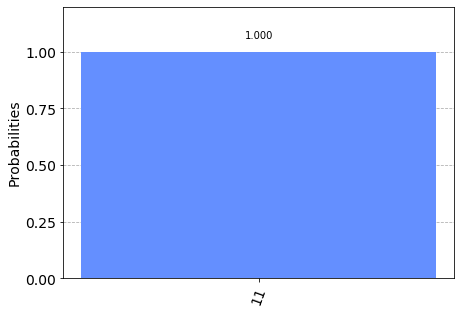

In [84]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#displaying the final results
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots = shots, parameter_binds = [{p1:parameter_val}])
result = job.result().get_counts()

plot_histogram(result)

We observe that as the shots decrease, the convergence of the 'parameter_val' to the desired values doesn't take palce. This is because the empirically obtained probability, no longer remains a correct measure of the real probability of collapse into states |00> or |11>. 

The value of 'parameter_val' obtained for 1000, 100 shots is a decent estimate of the its desired value. For 10 shots, the convergence is poor and for 1 shot the algorithm doesn't converge at all.